# Pratice 1.2 Quantum Neural Networks

MQIST 2025/26: Quantum Computing and Machine Learning

Alfredo Chavert Sancho

Pedro Herrero Maldonado

## Data loading and preprocessing

The `load_breast_cancer` function from `sklearn.datasets` is used to load the breast cancer dataset. This dataset contains features computed from breast cancer biopsy images, along with labels indicating whether the cancer is malignant or benign. So this is a binary classification problem. There are 30 features in total and 569 samples which are divided into:

- 357 benign samples labeled as 1
- 212 malignant samples labeled as 0

As measure to evaluate the performance of our quantum neural network, we will use **recall** of the positive class labeled with 0, which is the ratio of correctly predicted positive malignant cases to the total actual positive instances in the dataset (true positives and false negatives). 
$$
\text{Recall} = \frac{\text{True Malignant}}{\text{True Malignant} + \text{False Benign}}
$$

This is particularly important in medical diagnosis tasks, where minimizing false negatives (i.e., failing to identify actual positive cases) is crucial. Therefore, our goal in this work is to maximize this metric in our experiments.

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data # features
y = data.target # labels

print("Original shape:", X.shape)

Original shape: (569, 30)


For the prepocessing the data to be used in the quantum neural network, we will use  ``StandardScaler`` from ``sklearn.preprocessing`` to normalize it  since all the data is numeric.

We will also use ``PCA`` from ``sklearn.decomposition`` to reduce the dimensionality of the data to reduce the number of qubits needed in the quantum neural network. This transformation helps in capturing the most significant variance in the data while reducing its complexity.

For the sake of visualization, we will reduce the data to 2 principal components. However, for the quantum neural network, we will experiment with different numbers of principal components (3, 4, and 5) to see how it affects the model's performance.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Standardize (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (ex: reduce to 2 components for visualization or QML input)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape) # (150, 2)
print("Explained variance:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Shape after PCA: (569, 2)
Explained variance: [0.44272026 0.18971182]
Total variance explained: 0.6324320765155946


- PC1 (0.44): The first dimension alone holds 44.3% of the information in your dataset. This is the single strongest pattern in the data (likely related to the overall size/magnitude of the tumor cells).

- PC2 (0.19): The second dimension adds another 19.0% of distinct information (likely related to the shape/irregularity of the cells).

Total (0.63): When you combine them, you are preserving 63.2% of the original data's structure. For visualization purposes, this is often sufficient to see meaningful patterns.

Visualize the data to be used in the quantum neural network. 

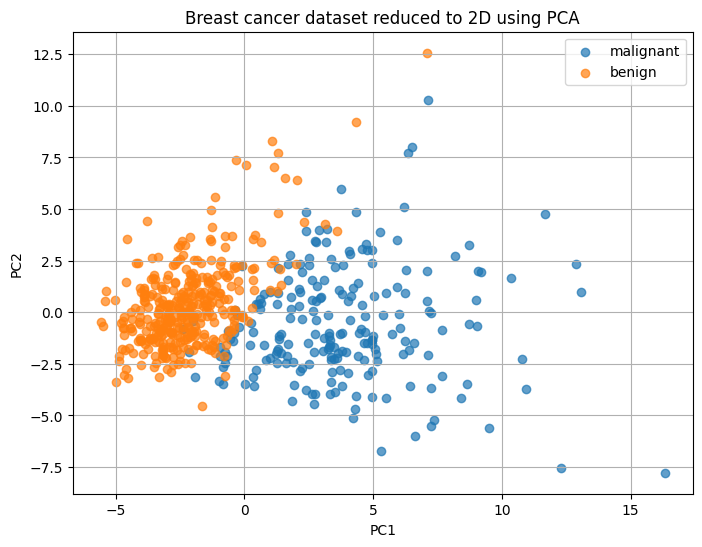

In [4]:
# Plot the result
plt.figure(figsize=(8,6))
for label in [0, 1]:
    plt.scatter(
                X_pca[y == label, 0],
                X_pca[y == label, 1],
                label=data.target_names[label],
                alpha=0.7
                )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Breast cancer dataset reduced to 2D using PCA")
plt.legend()
plt.grid(True)
plt.show()

As we see in the plot, the two classes (malignant and benign) are somewhat separable in this 2D PCA space, which is promising for classification tasks using a quantum neural network.

To ensure better total variance retention, we will consider enough principal components to capture at least 79% of the variance in the dataset, so the number of components will be 4.

In [5]:
# Apply PCA 
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape)
print("Explained variance:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Shape after PCA: (569, 4)
Explained variance: [0.44272026 0.18971182 0.09393163 0.06602135]
Total variance explained: 0.7923850582446098


Finally, we will split the dataset into training and testing sets using ``train_test_split`` from ``sklearn.model_selection``. This allows us to train the quantum neural network on one portion of the data and evaluate its performance on unseen data.

In [6]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

# Set the seed so results are reproducible
algorithm_globals.random_seed = 42

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=0.2, random_state=algorithm_globals.random_seed,
)

## Quantum neural network to predict class of each case

Here, we will implement a quantum neural network (QNN) using Qiskit to classify the breast cancer dataset. The QNN will consist of a feature map to encode the classical data into quantum states and an ansatz (variational circuit) to learn the classification boundaries. Those are the different parameters we will try and compare.

### Feature map

Lets choose a **Feature map** to represent the data in a quantum state

In [7]:
# Number of features after PCA
num_features = X_pca.shape[1]
print(f'The number of features after PCA is: {num_features}')

from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap

'Choose a feature map to represent the data in a quantum state'
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

Pauli_feature_map = PauliFeatureMap(feature_dimension = num_features,
                                    reps = 3,
                                    paulis = ['ZZ', 'XX', 'YY'],
                                    entanglement = 'linear')

feature_map = Z_feature_map

The number of features after PCA is: 4


### Ansatz

Next, we will choose a **Variational form (ansatz)** for our quantum neural network

In [8]:
from qiskit.circuit.library import RealAmplitudes, TwoLocal, NLocal, EfficientSU2

'Choose a variational form (ansatz) for our quantum neural network'
real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 3, 
                                        name = 'RealAmplitudes')

two_local_ansatz = TwoLocal(num_qubits = num_features, 
                            rotation_blocks = 'ry', 
                            entanglement_blocks = 'cz', 
                            reps = 3, 
                            name = 'TwoLocal')

esu2_ansatz = EfficientSU2(num_qubits = num_features, 
                           entanglement = 'full', 
                           reps = 3, 
                           name = 'EfficientSU2')


ansatz = real_amplitudes_ansatz

### Optimizer

An **optimizer** is needed to minimize the loss function during the training of the quantum neural network. In this case, we will use the COBYLA and SPSA optimizers from Qiskit, although other optimizers can also be used.

In [16]:
from qiskit_machine_learning.optimizers import COBYLA, SPSA

### Variational Quantum Classifier

Finally let's build a Variational Quantum Classifier (VQC) using this feature map, ansatz and optimizer.

But first, we will define a callback function to visualize the training progress.

0.9429125509686931


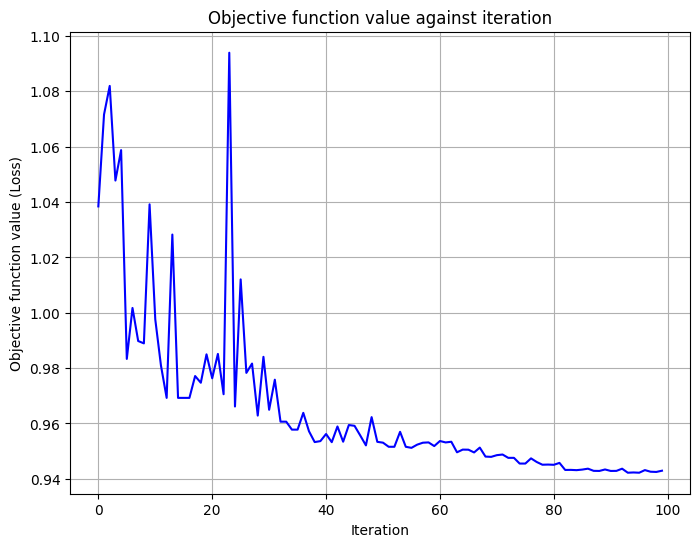

Training time: 274 seconds


In [11]:
import matplotlib.pyplot as plt
from qiskit_machine_learning.algorithms.classifiers import VQC
from IPython.display import clear_output 
import time

# Initialize the storage for the plot
objective_func_vals = []

# Define the callback
def callback_graph(_weights, _obj_func_eval):
    '''Callback function to visualize training progress
    
    Parameters:
        weights : Current parameters of the ansatz.
        obj_func_eval : Current loss value (error rate).
    '''
    
    clear_output(wait=True) # Clear previous output to update the plot
    print(_obj_func_eval)
    objective_func_vals.append(_obj_func_eval)
    
    plt.figure(figsize=(8,6))
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value (Loss)")
    plt.plot(range(len(objective_func_vals)), objective_func_vals, color='blue')
    plt.grid(True)
    plt.show()

vqc = VQC(
    feature_map = feature_map,
    ansatz = ansatz,
    optimizer = COBYLA(maxiter=100),
    callback = callback_graph)
start = time.time()

vqc.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

### Results for the VQC

This model is our first approach to implementing a quantum neural network (QNN) for classification using Qiskit.From this model we will try to improve it by changing the different parameters (number of PCA components, feature map, ansatz and optimizer) and compare the results in the next sections.

In [15]:
from sklearn.metrics import recall_score, classification_report

In [ ]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

y_pred = vqc.predict(X_test)
recall_q4 = recall_score(y_test, y_pred)
report_q4 = classification_report(y_test, y_pred)

print(f"Quantum VQC accuracy on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC accuracy on the test dataset:     {test_score_q4:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_q4:.2f}")
print(report_q4)

Quantum VQC accuracy on the training dataset: 0.63
Quantum VQC accuracy on the test dataset:     0.61
Quantum VQC recall on the test dataset:     0.96
              precision    recall  f1-score   support

           0       0.40      0.05      0.08        43
           1       0.62      0.96      0.76        71

    accuracy                           0.61       114
   macro avg       0.51      0.50      0.42       114
weighted avg       0.54      0.61      0.50       114



We can see that the accuracy is low (regarding our limited data representation due to the PCA), but the model doesn't present overfitting.

## Testing feature maps

First, we are going to test some typical feature maps for the VQC, with the same ansatz and optimizer, to better asses its performance.

### ZZ Feature Map

0.9516479918141939


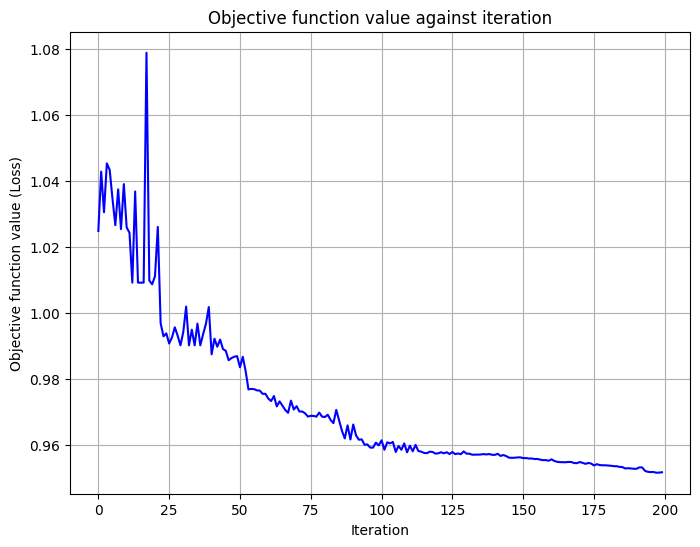

Training time: 313 seconds


In [12]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, reps = 3, name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_ZZ_RA_COBYLA = VQC(feature_map = ZZ_feature_map,
                       ansatz = real_amplitudes_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_ZZ_RA_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [13]:
train_score_ZZ_RA_COBYLA = vqc_ZZ_RA_COBYLA.score(X_train, y_train)
test_score_ZZ_RA_COBYLA = vqc_ZZ_RA_COBYLA.score(X_test, y_test)

y_pred_ZZ_RA_COBYLA = vqc_ZZ_RA_COBYLA.predict(X_test)
recall_ZZ_RA_COBYLA = recall_score(y_test, y_pred_ZZ_RA_COBYLA)
report_ZZ_RA_COBYLA = classification_report(y_test, y_pred_ZZ_RA_COBYLA)

print(f"ZZ Feature map accuracy on the training dataset: {train_score_ZZ_RA_COBYLA:.2f}")
print(f"ZZ Feature map accuracy on the test dataset:     {test_score_ZZ_RA_COBYLA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_ZZ_RA_COBYLA:.2f}")
print(report_ZZ_RA_COBYLA)

ZZ Feature map accuracy on the training dataset: 0.60
ZZ Feature map accuracy on the test dataset:     0.56
Quantum VQC recall on the test dataset:     0.75
              precision    recall  f1-score   support

           0       0.38      0.26      0.31        43
           1       0.62      0.75      0.68        71

    accuracy                           0.56       114
   macro avg       0.50      0.50      0.49       114
weighted avg       0.53      0.56      0.54       114



### Pauli Feature Map

0.9284973151897875


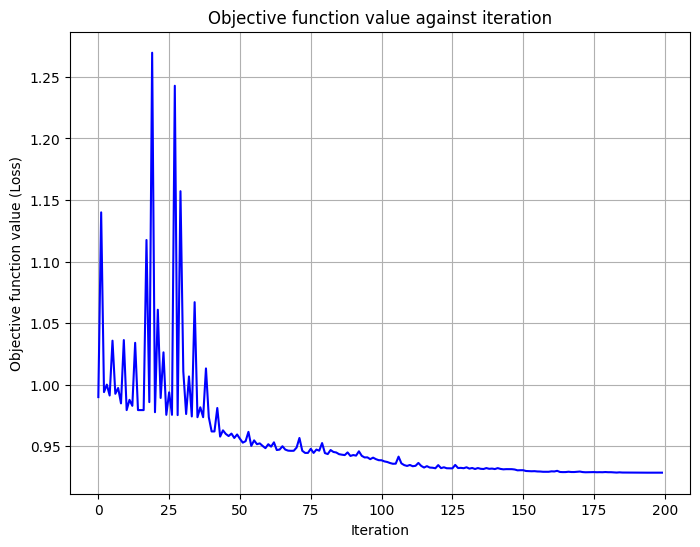

Training time: 594 seconds


In [14]:
Pauli_feature_map = PauliFeatureMap(feature_dimension = num_features,
                                    reps = 3,
                                    paulis = ['ZZ', 'XX', 'YY'],
                                    entanglement = 'linear')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, reps = 3, name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_Pauli_RA_COBYLA = VQC(feature_map = Pauli_feature_map,
                       ansatz = real_amplitudes_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_Pauli_RA_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [15]:
train_score_Pauli_RA_COBYLA = vqc_Pauli_RA_COBYLA.score(X_train, y_train)
test_score_Pauli_RA_COBYLA = vqc_Pauli_RA_COBYLA.score(X_test, y_test)

y_pred_Pauli_RA_COBYLA = vqc_Pauli_RA_COBYLA.predict(X_test)
recall_Pauli_RA_COBYLA = recall_score(y_test, y_pred_Pauli_RA_COBYLA)
report_Pauli_RA_COBYLA = classification_report(y_test, y_pred_Pauli_RA_COBYLA)

print(f"Pauli Feature map accuracy on the training dataset: {train_score_Pauli_RA_COBYLA:.2f}")
print(f"Pauli Feature map accuracy on the test dataset:     {test_score_Pauli_RA_COBYLA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_Pauli_RA_COBYLA:.2f}")
print(report_Pauli_RA_COBYLA)

Pauli Feature map accuracy on the training dataset: 0.63
Pauli Feature map accuracy on the test dataset:     0.60
Quantum VQC recall on the test dataset:     0.89
              precision    recall  f1-score   support

           0       0.38      0.12      0.18        43
           1       0.62      0.89      0.73        71

    accuracy                           0.60       114
   macro avg       0.50      0.50      0.46       114
weighted avg       0.53      0.60      0.52       114



The best feature map for this problem is the ZZ Feature Map, as it achieves the highest recall on the positive class (malignant cases) compared to the Pauli Feature Map. The following table summarizes the results:

| **Feature Map** |  Z Feature Map  |  ZZ Feature Map | Pauli Feature Map | 
|:---------------:|:---------------:|:---------------:|:-----------------:|
|    **Ansatz**   | Real Amplitudes | Real Amplitudes |  Real Amplitudes  |
|  **Optimizer**  |      COBYLA     |      COBYLA     |       COBYLA      |
|    **Recall**   |      $0.05$     |      $0.26$     |       $0.12$      |

## Testing Ansatzs

Feature map fixed to ZZFeatureMap and optimizer to COBYLA, now we will test different ansatzs for the VQC.

### Two Local Ansatz

0.9384249363686958


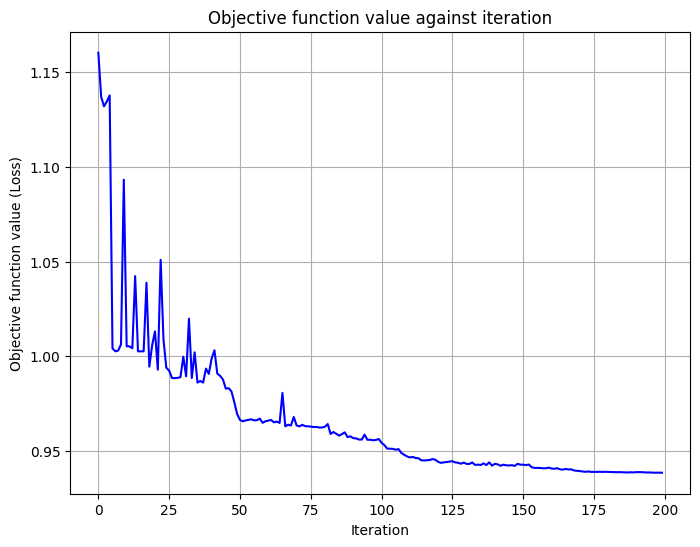

Training time: 910 seconds


In [ ]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

two_local_ansatz = TwoLocal(num_qubits = num_features, 
                            rotation_blocks = 'ry', 
                            entanglement_blocks = 'cz', 
                            reps = 3, 
                            name = 'TwoLocal')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_Z_2L_COBYLA = VQC(feature_map = ZZ_feature_map,
                       ansatz = two_local_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()



objective_func_vals = []
vqc_Z_2L_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [17]:
train_score_Z_2L_COBYLA = vqc_Z_2L_COBYLA.score(X_train, y_train)
test_score_Z_2L_COBYLA = vqc_Z_2L_COBYLA.score(X_test, y_test)

y_pred_Z_2L_COBYLA = vqc_Z_2L_COBYLA.predict(X_test)
recall_Z_2L_COBYLA = recall_score(y_test, y_pred_Z_2L_COBYLA)
report_Z_2L_COBYLA = classification_report(y_test, y_pred_Z_2L_COBYLA)

print(f"Two local ansatz accuracy on the training dataset: {train_score_Z_2L_COBYLA:.2f}")
print(f"Two local ansatz accuracy on the test dataset:     {test_score_Z_2L_COBYLA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_Z_2L_COBYLA:.2f}")
print(report_Z_2L_COBYLA)

Two local ansatz accuracy on the training dataset: 0.59
Two local ansatz accuracy on the test dataset:     0.59
Quantum VQC recall on the test dataset:     0.75
              precision    recall  f1-score   support

           0       0.44      0.33      0.37        43
           1       0.65      0.75      0.69        71

    accuracy                           0.59       114
   macro avg       0.54      0.54      0.53       114
weighted avg       0.57      0.59      0.57       114



### ESU2 Ansatz

0.9186111713513598


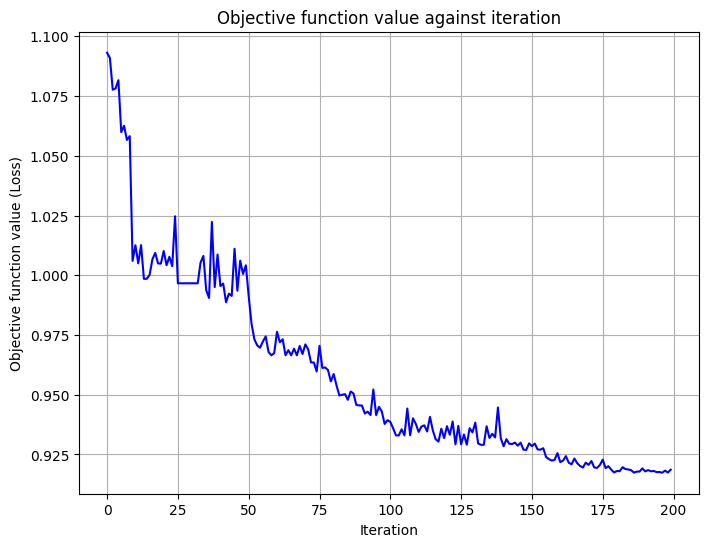

Training time: 756 seconds


In [18]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

esu2_ansatz = EfficientSU2(num_qubits = num_features, 
                           entanglement = 'full', 
                           reps = 3, 
                           name = 'EfficientSU2')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_Z_ESU2_COBYLA = VQC(feature_map = ZZ_feature_map,
                       ansatz = esu2_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()


objective_func_vals = []
vqc_Z_ESU2_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [19]:
train_score_Z_ESU2_COBYLA = vqc_Z_ESU2_COBYLA.score(X_train, y_train)
test_score_Z_ESU2_COBYLA = vqc_Z_ESU2_COBYLA.score(X_test, y_test)

y_pred_Z_ESU2_COBYLA  = vqc_Z_ESU2_COBYLA.predict(X_test)
recall_Z_ESU2_COBYLA  = recall_score(y_test, y_pred_Z_ESU2_COBYLA )
report_Z_ESU2_COBYLA = classification_report(y_test, y_pred_Z_ESU2_COBYLA)

print(f"ESU2 ansatz accuracy on the training dataset: {train_score_Z_ESU2_COBYLA:.2f}")
print(f"ESU2 ansatz accuracy on the test dataset:     {test_score_Z_ESU2_COBYLA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_Z_ESU2_COBYLA:.2f}")
print(report_Z_ESU2_COBYLA)

ESU2 ansatz accuracy on the training dataset: 0.65
ESU2 ansatz accuracy on the test dataset:     0.60
Quantum VQC recall on the test dataset:     0.79
              precision    recall  f1-score   support

           0       0.44      0.28      0.34        43
           1       0.64      0.79      0.71        71

    accuracy                           0.60       114
   macro avg       0.54      0.53      0.53       114
weighted avg       0.57      0.60      0.57       114



The following table summarizes the results of the different ansatzs tested with the ZZ Feature Map and COBYLA optimizer:

| **Feature Map** | ZZ Feature Map | ZZ Feature Map |
|:---------------:|:-------------:|:-------------:|
|    **Ansatz**   |    TwoLocal   |      ESU2     |
|  **Optimizer**  |     COBYLA    |     COBYLA    |
|    **Recall**   |     $0.33$    |     $0.28$    |

We see that the Two Local Ansatz outperforms the ESU2 Ansatz in terms of recall for the positive class (malignant cases). Therefore, for this specific classification task using the breast cancer dataset, the Two Local Ansatz is the better choice when combined with the ZZ Feature Map and COBYLA optimizer.

## Testing Optimizers

### SPSA Optimizer

In [20]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                            reps = 3,
                            entanglement = 'linear')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 3, 
                                        name = 'RealAmplitudes')

spsa_optimizer = SPSA(maxiter = 100)

vqc_Z_RA_SPSA = VQC(feature_map = ZZ_feature_map,
                       ansatz = real_amplitudes_ansatz,
                       optimizer = spsa_optimizer)
start = time.time()


objective_func_vals = []
vqc_Z_RA_SPSA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

Training time: 680 seconds


In [21]:
train_score_Z_RA_SPSA = vqc_Z_RA_SPSA.score(X_train, y_train)
test_score_Z_RA_SPSA = vqc_Z_RA_SPSA.score(X_test, y_test)

y_pred_Z_RA_SPSA  = vqc_Z_RA_SPSA.predict(X_test)
recall_Z_RA_SPSA  = recall_score(y_test, y_pred_Z_RA_SPSA )
report_Z_RA_SPSA = classification_report(y_test, y_pred_Z_RA_SPSA)

print(f"SPSA optimizer accuracy on the training dataset: {train_score_Z_RA_SPSA:.2f}")
print(f"SPSA optimizer accuracy on the test dataset:     {test_score_Z_RA_SPSA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_Z_RA_SPSA:.2f}")
print(report_Z_RA_SPSA)

SPSA optimizer accuracy on the training dataset: 0.56
SPSA optimizer accuracy on the test dataset:     0.46
Quantum VQC recall on the test dataset:     0.63
              precision    recall  f1-score   support

           0       0.24      0.19      0.21        43
           1       0.56      0.63      0.60        71

    accuracy                           0.46       114
   macro avg       0.40      0.41      0.40       114
weighted avg       0.44      0.46      0.45       114



The following table summarizes the results of the different optimizers tested with the ZZ Feature Map and Real Amplitudes ansatz:

| **Feature Map** | ZZ Feature Map     |  ZZ Feature Map |
|:---------------:|:-------------:     |:---------------:|
|    **Ansatz**   |    Real Amplitudes | Real Amplitudes |  
|  **Optimizer**  |     SPSA           |      COBYLA     |
|    **Recall**   |     $0.19$         |      $0.26$     |
   
We see that the COBYLA optimizer outperforms the SPSA optimizer in terms of recall for the positive class (malignant cases). Therefore, for this specific classification task using the breast cancer dataset, the COBYLA optimizer is the better choice when combined with the ZZ Feature Map and Real Amplitudes ansatz.



# Changing parameters on the best performing problem

For this section, we will use the ZZ Feature Map, Real Amplitudes ansatz, and COBYLA optimizer, and different parameters will be tested to see how they affect the model's performance. 
| **Feature Map** | ZZ Feature Map     |
|:---------------:|:-------------:     |
|    **Ansatz**   |    Real Amplitudes |  
|  **Optimizer**  |     COBYLA         |
|    **Recall**   |     $0.26$         |

## More epochs

0.9288527509170501


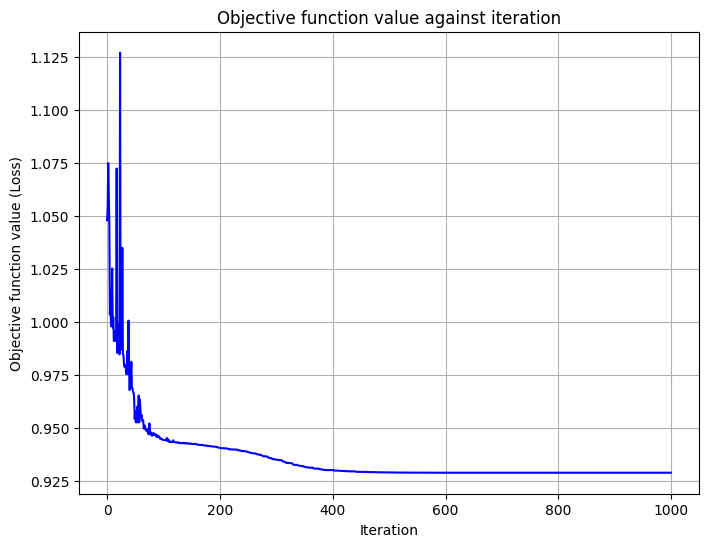

Training time: 1432 seconds


In [29]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, reps = 3, name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 1000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [30]:
train_score_best = vqc_best.score(X_train, y_train)
test_score_best = vqc_best.score(X_test, y_test)

y_pred_best  = vqc_best.predict(X_test)
recall_best  = recall_score(y_test, y_pred_best )
report_best = classification_report(y_test, y_pred_best)

print(f"Best model accuracy on the training dataset: {train_score_best:.2f}")
print(f"Best model accuracy on the test dataset:     {test_score_best:.2f}")
print(f"Best model recall on the test dataset:     {recall_best:.2f}")
print(report_best)

Best model accuracy on the training dataset: 0.62
Best model accuracy on the test dataset:     0.59
Best model recall on the test dataset:     0.85
              precision    recall  f1-score   support

           0       0.39      0.16      0.23        43
           1       0.62      0.85      0.72        71

    accuracy                           0.59       114
   macro avg       0.51      0.50      0.47       114
weighted avg       0.54      0.59      0.53       114



The recall is $0.16$, which is lower than before as is shown in the table above. Thus , increasing the number of epochs did not improve the model's performance in terms of recall for the positive class (malignant cases).

## More entanglement

0.92947886101527


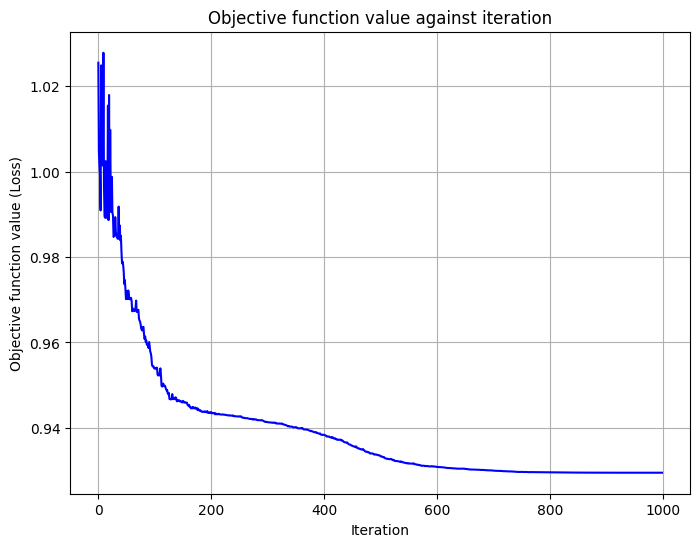

Training time: 1804 seconds


In [31]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'full')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 3, 
                                        name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 1000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best2 = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best2.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [32]:
y_pred_best2  = vqc_best2.predict(X_test)
report_best2 = classification_report(y_test, y_pred_best2)
print(report_best2)

              precision    recall  f1-score   support

           0       0.34      0.33      0.33        43
           1       0.60      0.62      0.61        71

    accuracy                           0.51       114
   macro avg       0.47      0.47      0.47       114
weighted avg       0.50      0.51      0.51       114



The recall with more entanglement is $0.33$ is higher than before as is shown in the table above. Thus , increasing the entanglement improved the model's performance in terms of recall for the positive class (malignant cases).

## More feature map reps

0.9535550736993287


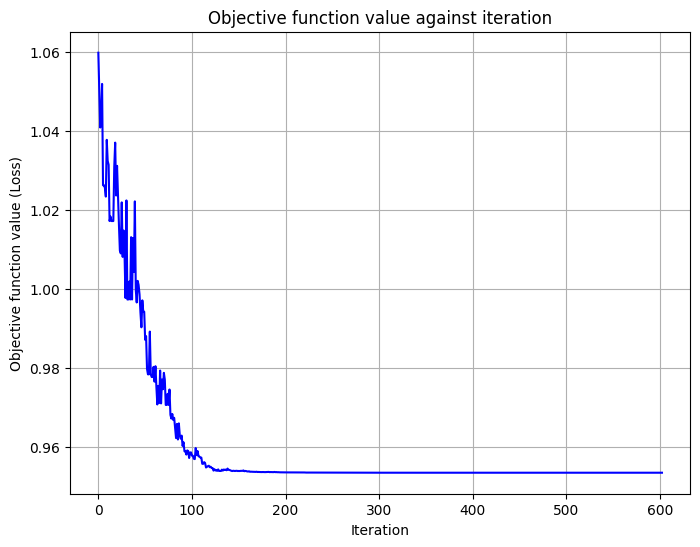

Training time: 1532 seconds


In [33]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 5,
                              entanglement = 'full')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 3, 
                                        name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 1000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best3 = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best3.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [34]:
y_pred_best3  = vqc_best3.predict(X_test)
report_best3 = classification_report(y_test, y_pred_best3)
print(report_best3)

              precision    recall  f1-score   support

           0       0.33      0.37      0.35        43
           1       0.59      0.55      0.57        71

    accuracy                           0.48       114
   macro avg       0.46      0.46      0.46       114
weighted avg       0.49      0.48      0.49       114



The recall is $0.37$, which is slightly higher than before as is shown in the table above. Thus , increasing the number of repetitions in the feature map improved the model's performance in terms of recall for the positive class.

## More ansatz reps

0.9407346569594558


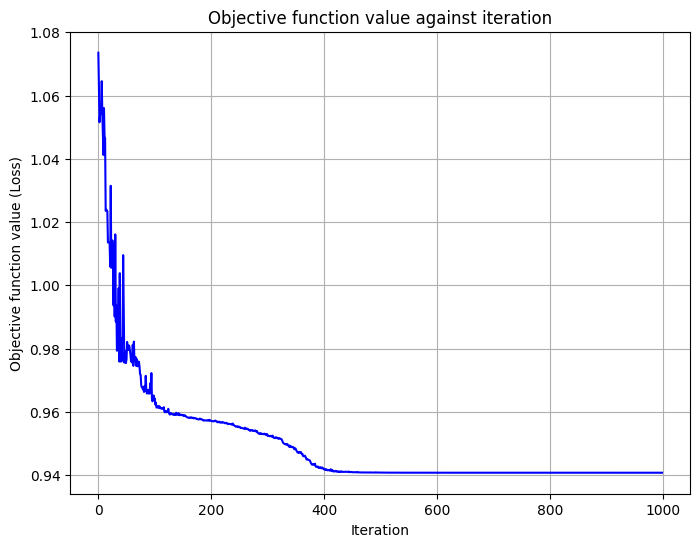

Training time: 2626 seconds


In [35]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 5,
                              entanglement = 'full')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 4, 
                                        name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 1000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best4 = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best4.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [37]:
y_pred_best4  = vqc_best4.predict(X_test)
report_best4 = classification_report(y_test, y_pred_best4)
print(report_best4)

              precision    recall  f1-score   support

           0       0.33      0.33      0.33        43
           1       0.60      0.61      0.60        71

    accuracy                           0.50       114
   macro avg       0.47      0.47      0.47       114
weighted avg       0.50      0.50      0.50       114



The recall is $0.33$, which is better than in the original model. Thus, increasing the number of repetitions in the ansatz improved the model's performance in terms of recall for the positive class.

Taking the following table into account:
| **Feature Map** | ZZ Feature Map     |
|:---------------:|:-------------:     |
|    **Ansatz**   |    Real Amplitudes |  
|  **Optimizer**  |     COBYLA         |
|    **Recall**   |     $0.33$         |

The summary of the results obtained in this section is as follows:

| Parameters adjusted | Recall |
|---------------------|--------|
| More epochs         | 0.16   |
| More entanglement   | 0.33   |
| More feature map reps| 0.37  |
| More ansatz reps    | 0.33   |



## More PCA components for the best performing model (Final model)

In the final model we will increase the number of PCA components to 7 which will allow us to capture more variance in the data and potentially improve the model's performance.

In [ ]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape) 
print("Explained variance:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Shape after PCA: (569, 7)
Explained variance: [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734]
Total variance explained: 0.9100953006967311


In [7]:
algorithm_globals.random_seed = 42

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = algorithm_globals.random_seed)

In [11]:
def callback_graph(_weights, _obj_func_eval):
    '''Callback function to visualize training progress
    
    Parameters:
        weights : Current parameters of the ansatz.
        obj_func_eval : Current loss value (error rate).
    '''
    
    clear_output(wait=True) # Clear previous output to update the plot
    print(_obj_func_eval)
    objective_func_vals.append(_obj_func_eval)
    
    plt.figure(figsize=(8,6))
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value (Loss)")
    plt.plot(range(len(objective_func_vals)), objective_func_vals, color='blue')
    plt.grid(True)
    plt.show()


Taking all the previous results into account, the best performing model uses the ZZ Feature Map, Real Amplitudes Ansatz, and COBYLA optimizer, with 7 PCA components.

0.95664049973259


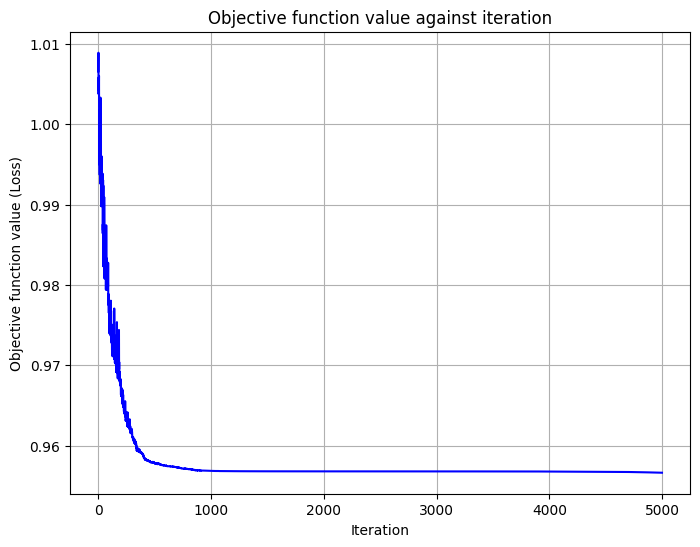

Training time: 39580 seconds


In [13]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA
from sklearn.metrics import recall_score, classification_report
from qiskit_machine_learning.algorithms.classifiers import VQC
from IPython.display import clear_output 
import time

num_features = X_pca.shape[1]
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 5,
                              entanglement = 'full')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 4, 
                                        name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 5000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best4 = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best4.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [14]:
y_pred_best4  = vqc_best4.predict(X_test)
report_best4 = classification_report(y_test, y_pred_best4)
print(report_best4)

              precision    recall  f1-score   support

           0       0.40      0.51      0.45        43
           1       0.64      0.54      0.58        71

    accuracy                           0.53       114
   macro avg       0.52      0.52      0.52       114
weighted avg       0.55      0.53      0.53       114



In [15]:
vqc_best4.save('big_model.keras')